In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# transforms.Compose : 이미지에 적용할 여러 변환을 묶는 역할
    # transforms.ToTensor() : 이미지를 텐서로 변환 -> 픽셀 값을 0-255 -> 0-1 사이로 정규화
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) : 각 색상 채널(빨강, 초록, 파랑)의 픽셀 값 범위를 -1 ~ 1 사이로 정규화

transfrom = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256 # 전체(목표) 배치 크기
sub_batch_size = 32 # 부분 배치 크기

# 데이터셋 다운로드
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transfrom)

# 데이터셋 불러오기
# DataLoader : 데이터셋을 배치 단위로 관리하는 역할
    # batch_size : 배치 크기
    # shuffle : 데이터를 섞을지 여부
    # num_workers : 데이터 로드에 사용할 쓰레드 수
train_loader = torch.utils.data.DataLoader(full_trainset, batch_size=sub_batch_size, shuffle=True, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [134]:
# 전체 데이터를 70:15:15로 분할
from torch.utils.data import random_split

# Train 데이터를 70%로 분할
train_size = int(0.7 * len(full_trainset))
val_size = int(0.15 * len(full_trainset))
test_size = len(full_trainset) - train_size - val_size

datasets = random_split(full_trainset, [train_size, val_size, test_size])

trainset = datasets[0]
valset = datasets[1]
testset = datasets[2]

# 각각의 DataLoader 생성
train_loader = torch.utils.data.DataLoader(trainset, batch_size=sub_batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(valset, batch_size=sub_batch_size, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(testset, batch_size=sub_batch_size, shuffle=False, num_workers=0)


In [135]:
import torch.nn as nn
import torch.nn.functional as F

# PlainNetBlock : 18 layer plain net의 기본 블록
class PlainNetBlock(nn.Module):
    expansion = 1

    # 초기화 함수
    def __init__(self, in_planes, planes, stride=1):
        super(PlainNetBlock, self).__init__()

        # 첫 번째 컨볼루션 레이어
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # 두 번째 컨볼루션 레이어
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return out

# ResNetBasicBlock : ResNet의 기본 블록
class ResNetBasicBlock(nn.Module):
    expansion = 1

    # 초기화 함수
    def __init__(self, in_planes, planes, stride=1):
        super(ResNetBasicBlock, self).__init__()

        # 첫 번째 컨볼루션 레이어
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # 두 번째 컨볼루션 레이어
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # 축약 경로(shortcut) 설정
        self.shortcut = nn.Sequential()

        # Input 크기가 변경되는 경우, Output 크기와 일치시키기 위해 1x1 컨볼루션 추가
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )
    
    # 순전파 함수
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # 축약 경로 추가
        out = F.relu(out)
        return out

# ResNetBottleneck : ResNet의 병목 블록
class ResNetBottleneck(nn.Module):
    expansion = 4

    # 초기화 함수
    def __init__(self, in_planes, planes, stride=1):
        super(ResNetBottleneck, self).__init__()

        # 첫 번째 컨볼루션 레이어
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # 두 번째 컨볼루션 레이어
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # 세 번째 컨볼루션 레이어
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        # 축약 경로(shortcut) 설정
        self.shortcut = nn.Sequential()

        # Input 크기가 변경되는 경우, Output 크기와 일치시키기 위해 1x1 컨볼루션 추가
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

    # 순전파 함수
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x) # 축약 경로 추가
        out = F.relu(out)
        return out

In [136]:
# net class
class Net(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(Net, self).__init__()
        self.in_planes = 64

        # 채널 수 3 -> 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # _make_layer 함수 호출하여 여러 개의 블록 그룹 생성
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # average pooling 레이어 사용
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # 완전 연결 레이어(Fully Connected Layer) 512 * block.expansion -> 10개의 클래스로 분류
        self.fc = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1) # 첫 번째 블록은 stride, 나머지는 1
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion # 채널 수 증가
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)  # 텐서를 평탄화 (배치 크기, 512)
        out = self.fc(out)
        return out

In [137]:
# 18 layer plain net
planet_18 = Net(PlainNetBlock, [2, 2, 2, 2])
planet_18_loss = []
planet_18_error = []
    
# 18 layer resnet
resnet_18 = Net(ResNetBasicBlock, [2, 2, 2, 2])
resnet_18_loss = []
resnet_18_error = []

# 50 layer resnet
resnet_50 = Net(ResNetBottleneck, [3, 4, 6, 3])
resnet_50_loss = []
resnet_50_error = []

In [138]:
import torch.optim as optim

# 크로스 엔트로피 손실 함수 사용
criterion = nn.CrossEntropyLoss()

# 학습률 0.0001, 모멘텀 0.9
## 학습률 0.01로 변경 (결과 값이 계획 값하고 달라서)
planet_18_optimizer = optim.SGD(planet_18.parameters(), lr=0.0001, momentum=0.9)
resnet_18_optimizer = optim.SGD(resnet_18.parameters(), lr=0.0001, momentum=0.9)
resnet_50_optimizer = optim.SGD(resnet_50.parameters(), lr=0.0001, momentum=0.9)

# 3번 에포크 학습
num_epochs = 3

In [139]:
# 평가 함수 (top1 error rate, top5 error rate)
def evaluate_model(model, data_loader, is_top5=False):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            
            if is_top5:
                _, top5 = outputs.topk(5, dim=1)
                total_correct += (top5 == labels.unsqueeze(1)).any(dim=1).sum().item()
            else:
                _, predicted = torch.max(outputs.data, 1)
                total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    return (1 - total_correct / total_samples) * 100           

In [ ]:
# model 학습
for epoch in range(num_epochs):
    running_loss_planet_18 = 0.0
    running_loss_resnet_18 = 0.0
    running_loss_resnet_50 = 0.0

    accumulated_steps = batch_size // sub_batch_size # 누적 배치 크기
    
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # 순전파 + 역전파 + 최적화
        outputs_planet_18 = planet_18(inputs)
        outputs_resnet_18 = resnet_18(inputs)
        outputs_resnet_50 = resnet_50(inputs)

        loss_planet_18 = criterion(outputs_planet_18, labels)
        loss_resnet_18 = criterion(outputs_resnet_18, labels)
        loss_resnet_50 = criterion(outputs_resnet_50, labels)

        loss_planet_18.backward()
        loss_resnet_18.backward()
        loss_resnet_50.backward()

        # 배치 손실 합계 계산
        running_loss_planet_18 += loss_planet_18.item()
        running_loss_resnet_18 += loss_resnet_18.item()
        running_loss_resnet_50 += loss_resnet_50.item()
        
        # 8번마다 파라미터 업데이트(256/32 = 8) -> gradient 누적
        if (i + 1) % accumulated_steps == 0:
            ## planet_18
            planet_18_optimizer.step() # 파라미터 업데이트
            planet_18_optimizer.zero_grad() # 변화도(gradient) 초기화
            
            ## resnet_18
            resnet_18_optimizer.step() # 파라미터 업데이트
            resnet_18_optimizer.zero_grad() # 변화도(gradient) 초기화

            ## resnet_50
            resnet_50_optimizer.step() # 파라미터 업데이트
            resnet_50_optimizer.zero_grad() # 변화도(gradient) 초기화

            # 매번 손실 기록 (8번의 배치 평균)
            avg_loss_planet_18 = running_loss_planet_18 / accumulated_steps
            planet_18_loss.append(avg_loss_planet_18)

            avg_loss_resnet_18 = running_loss_resnet_18 / accumulated_steps
            resnet_18_loss.append(avg_loss_resnet_18)

            avg_loss_resnet_50 = running_loss_resnet_50 / accumulated_steps
            resnet_50_loss.append(avg_loss_resnet_50)

            print(f"Step {i // accumulated_steps + 1}: planet_18 Loss = {avg_loss_planet_18:.4f}, resnet_18 Loss = {avg_loss_resnet_18:.4f}, resnet_50 Loss = {avg_loss_resnet_50:.4f}")

            # step 24마다 검증 데이터 평가
            if (i // accumulated_steps + 1) % 24 == 0:    
                val_error_planet_18 = evaluate_model(planet_18, val_loader)
                val_error_resnet_18 = evaluate_model(resnet_18, val_loader)
                val_error_resnet_50 = evaluate_model(resnet_50, val_loader)

                planet_18_error.append(val_error_planet_18)
                resnet_18_error.append(val_error_resnet_18)
                resnet_50_error.append(val_error_resnet_50)

                print(f"Step {i // accumulated_steps + 1}: planet_18 Error = {val_error_planet_18:.2f}, resnet_18 Error = {val_error_resnet_18:.2f}, resnet_50 Error = {val_error_resnet_50:.2f}")
                
            # running_loss 초기화 (다음 8번의 배치를 위해)
            running_loss_planet_18 = 0.0
            running_loss_resnet_18 = 0.0
            running_loss_resnet_50 = 0.0

    # 학습 루프가 끝난 후, 남은 그래디언트 처리
    if (len(train_loader) % accumulated_steps) != 0:
        planet_18_optimizer.step()
        planet_18_optimizer.zero_grad()

        resnet_18_optimizer.step()  
        resnet_18_optimizer.zero_grad()

        resnet_50_optimizer.step()
        resnet_50_optimizer.zero_grad()


Epoch 1/3
Step 1: planet_18 Loss = 2.3038, resnet_18 Loss = 2.3479, resnet_50 Loss = 2.3942
Step 2: planet_18 Loss = 2.2922, resnet_18 Loss = 2.3719, resnet_50 Loss = 2.4296
Step 3: planet_18 Loss = 2.2782, resnet_18 Loss = 2.3521, resnet_50 Loss = 2.3469
Step 4: planet_18 Loss = 2.2965, resnet_18 Loss = 2.3642, resnet_50 Loss = 2.3155
Step 5: planet_18 Loss = 2.2783, resnet_18 Loss = 2.3159, resnet_50 Loss = 2.3137
Step 6: planet_18 Loss = 2.2540, resnet_18 Loss = 2.3212, resnet_50 Loss = 2.2906
Step 7: planet_18 Loss = 2.2395, resnet_18 Loss = 2.2742, resnet_50 Loss = 2.2903
Step 8: planet_18 Loss = 2.2485, resnet_18 Loss = 2.2702, resnet_50 Loss = 2.3126
Step 9: planet_18 Loss = 2.2285, resnet_18 Loss = 2.2553, resnet_50 Loss = 2.3042
Step 10: planet_18 Loss = 2.2009, resnet_18 Loss = 2.2237, resnet_50 Loss = 2.2579
Step 11: planet_18 Loss = 2.1674, resnet_18 Loss = 2.2383, resnet_50 Loss = 2.2778
Step 12: planet_18 Loss = 2.2317, resnet_18 Loss = 2.2474, resnet_50 Loss = 2.3000
St

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000256C85B9940>
Traceback (most recent call last):
  File "c:\work\workspace-vom\env\Lib\site-packages\torch\utils\data\dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "c:\work\workspace-vom\env\Lib\site-packages\torch\utils\data\dataloader.py", line 1622, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


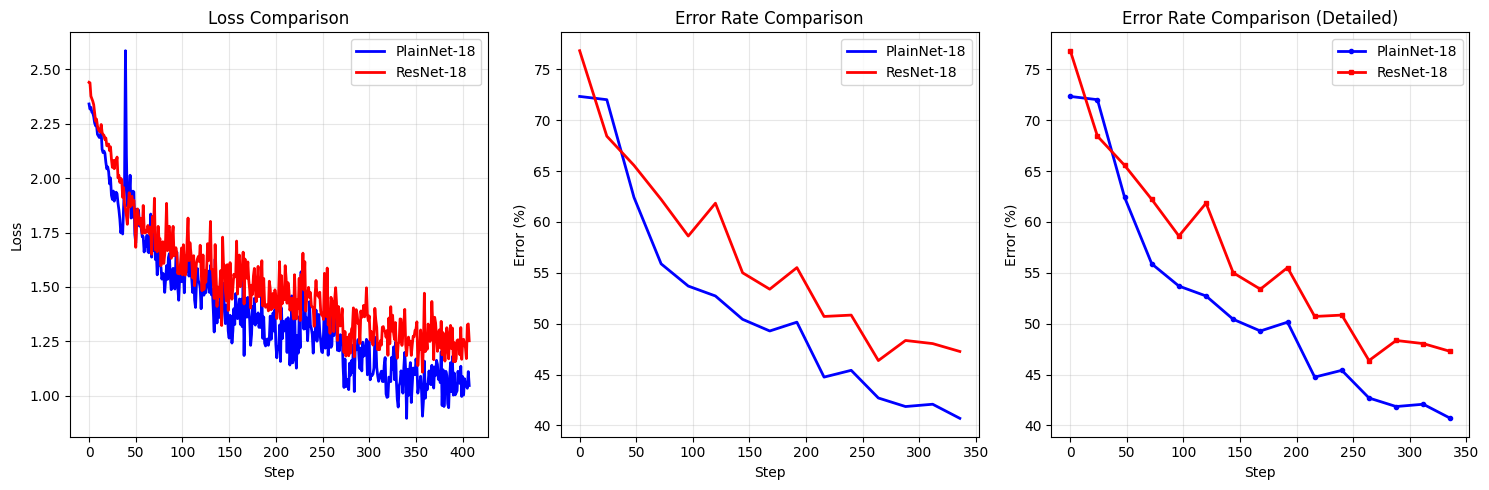

In [ ]:
# PlainNet과 ResNet 비교 그래프
plt.figure(figsize=(15, 5))
# 손실 비교 그래프
plt.subplot(1, 3, 1)
plt.plot(planet_18_loss, label='PlainNet-18', color='blue', linewidth=2)
plt.plot(resnet_18_loss, label='ResNet-18', color='red', linewidth=2)
plt.plot(resnet_50_loss, label='ResNet-50', color='green', linewidth=2)
plt.title("Loss Comparison")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# 오류율 step x 값 보정
x_values = [i * 24 for i in range(len(planet_18_error))]

# 오류율 비교 그래프
plt.subplot(1, 3, 2)
plt.plot(x_values, planet_18_error, label='PlainNet-18', color='blue', linewidth=2)
plt.plot(x_values, resnet_18_error, label='ResNet-18', color='red', linewidth=2)
plt.plot(x_values, resnet_50_error, label='ResNet-50', color='green', linewidth=2)
plt.title("Error Rate Comparison")
plt.xlabel("Step")
plt.ylabel("Error (%)")
plt.legend()
plt.grid(True, alpha=0.3)

# 오류율만 따로 비교 (더 큰 그래프)
plt.subplot(1, 3, 3)
plt.plot(x_values, planet_18_error, label='PlainNet-18', color='blue', linewidth=2, marker='o', markersize=3)
plt.plot(x_values, resnet_18_error, label='ResNet-18', color='red', linewidth=2, marker='s', markersize=3)
plt.plot(x_values, resnet_50_error, label='ResNet-50', color='green', linewidth=2, marker='^', markersize=3)
plt.title("Error Rate Comparison (Detailed)")
plt.xlabel("Step")
plt.ylabel("Error (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# 최종 테스트 오류율 비교
planet_18_test_top1_error = evaluate_model(planet_18, test_loader)
resnet_18_test_top1_error = evaluate_model(resnet_18, test_loader)
resnet_50_test_top1_error = evaluate_model(resnet_50, test_loader)  

planet_18_test_top5_error = evaluate_model(planet_18, test_loader, is_top5=True)
resnet_18_test_top5_error = evaluate_model(resnet_18, test_loader, is_top5=True)
resnet_50_test_top5_error = evaluate_model(resnet_50, test_loader, is_top5=True)

print(f"Planet-18 Top1 Error: {planet_18_test_top1_error:.2f}%, Top5 Error: {planet_18_test_top5_error:.2f}%")
print(f"ResNet-18 Top1 Error: {resnet_18_test_top1_error:.2f}%, Top5 Error: {resnet_18_test_top5_error:.2f}%")
print(f"ResNet-50 Top1 Error: {resnet_50_test_top1_error:.2f}%, Top5 Error: {resnet_50_test_top5_error:.2f}%")

Planet-18 Top1 Error: 42.36%, Top5 Error: 5.89%
ResNet-18 Top1 Error: 49.43%, Top5 Error: 7.75%
